In [1]:
import torch
import os
from utils.misc import list_img, unnormalize_data, visualize, normalize_data
from utils.model import Unet
from utils.transformations import get_preprocessing, get_training_augmentation
import segmentation_models_pytorch as smp
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics import PeakSignalNoiseRatio

In [2]:
model = Unet(
        encoder_name='resnet34', 
        encoder_weights='imagenet', 
        encoder_depth = 5,
        classes=1, 
        activation='tanh',
        fusion=True,
        contrastive=True,
    )
model.load_state_dict(torch.load('/home/aditya/Documents/ThermalModels/best_model_soft_lake.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
dir1 = '/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/train_val/validation/valid_VIS_HR'
dir2 = '/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/train_val/validation/valid_input_THER_LR_bicubic/X8'
dir3 = '/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/train_val/validation/valid_output_gt_THER_HR'
inputs1 = list_img(dir1)
inputs2 = list_img(dir2)
targets = list_img(dir3)

In [4]:
len(inputs1)

30

In [5]:
augmentation = get_training_augmentation()
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocessing = get_preprocessing(preprocessing_fn)
model.eval()
reshape = albu.Resize(480,640)
s = StructuralSimilarityIndexMeasure()
p = PeakSignalNoiseRatio()
avg_ssim = 0
for l in [0,10,20]:
    ssim=0
    psnr=0
    for ind in range(l,l+10):
        img1_ = cv2.imread(inputs1[ind])
        img1_ = cv2.cvtColor(img1_, cv2.COLOR_BGR2RGB)
        img2_ = cv2.imread(inputs2[ind])
        target = cv2.imread(targets[ind],0)
        target = target.reshape(480,640,1)
        # img1 = augmentation(image=img1_)['image']
        # img2 = augmentation(image=img2_)['image']
        # img1 = img1_
        img2_ = reshape(image=img2_)['image']
        sample = preprocessing(image=img1_, mask=target)
        img1, target = sample['image'], sample['mask']
        img2 = preprocessing(image=img2_)['image']
        target = target/255
        target = normalize_data(target)
        img1 = torch.from_numpy(img1).unsqueeze(0)
        img2 = torch.from_numpy(img2).unsqueeze(0)
        target = torch.from_numpy(target).unsqueeze(0)
        prd,_,_ = model(img1,img2)
        target = 255*unnormalize_data(target)
        prd = 255*unnormalize_data(prd)
        target = (target.type(torch.int)).type(torch.float)
        prd = (prd.type(torch.int)).type(torch.float)
        if ind == 0:
            print(f'prd:{prd} target:{target}')
        ssim = ssim+ s(prd,target)
        psnr = psnr+ p(prd,target)
        # print(f'ssim:{ssim} psnr:{psnr}')
        prd = prd.detach().numpy().squeeze(0).squeeze(0)
        target = target.detach().numpy().squeeze(0).squeeze(0)
        # prd = (prd*255).astype('uint8')
        # print(prd.shape,img1_.shape,img2_.shape)
        # plt.imshow(prd, cmap='gray')
        # visualize(pred=prd, target = target, therm = img2_)
        # plt.imsave('/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/submitStructure/evaluation/x8/'+str(lst[ind])+'.bmp', prd, cmap='gray')
    print(f'avg ssim:{ssim/10} avg psnr:{psnr/10}')
    avg_ssim = avg_ssim+ssim/10
print(f'total avg ssim:{avg_ssim/3}') 

prd:tensor([[[[ 84.,  74.,  76.,  ...,  78.,  82., 100.],
          [ 71.,  57.,  62.,  ...,  76.,  72.,  82.],
          [ 68.,  56.,  51.,  ...,  64.,  60.,  68.],
          ...,
          [213., 233., 243.,  ..., 234., 221., 207.],
          [191., 224., 235.,  ..., 228., 216., 198.],
          [163., 192., 212.,  ..., 213., 200., 175.]]]]) target:tensor([[[[ 73.,  72.,  72.,  ...,  72.,  80.,  84.],
          [ 74.,  72.,  71.,  ...,  87.,  93.,  92.],
          [ 74.,  73.,  71.,  ...,  87.,  84.,  76.],
          ...,
          [215., 215., 214.,  ..., 196., 196., 197.],
          [215., 215., 215.,  ..., 197., 197., 198.],
          [215., 215., 215.,  ..., 197., 198., 198.]]]])
avg ssim:0.7043201327323914 avg psnr:19.003042221069336
avg ssim:0.6523258090019226 avg psnr:18.814626693725586
avg ssim:0.6955395936965942 avg psnr:18.575685501098633
total avg ssim:0.6840618252754211


In [8]:
augmentation = get_training_augmentation()
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocessing = get_preprocessing(preprocessing_fn)
model.load_state_dict(torch.load('/home/aditya/Documents/ThermalModels/best_model_sweet_lion.pth', map_location=torch.device('cpu')))
model.eval()
reshape = albu.Resize(480,640)
s = StructuralSimilarityIndexMeasure()
p = PeakSignalNoiseRatio()
ssim=0
psnr=0
lst = ['evl_001','evl_002','evl_003','evl_004','evl_005','evl_006','evl_007','evl_008','evl_009','evl_010']
for ind in range(10):
    img1_ = cv2.imread(inputs1[ind])
    img1_ = cv2.cvtColor(img1_, cv2.COLOR_BGR2RGB)
    img2_ = cv2.imread(inputs2[ind])
    target = cv2.imread(targets[ind],0)
    target = target.reshape(480,640,1)
    # img1 = augmentation(image=img1_)['image']
    # img2 = augmentation(image=img2_)['image']
    # img1 = img1_
    img2_ = reshape(image=img2_)['image']
    sample = preprocessing(image=img1_, mask=target)
    img1, target = sample['image'], sample['mask']
    img2 = preprocessing(image=img2_)['image']
    target = target/255
    target = normalize_data(target)
    img1 = torch.from_numpy(img1).unsqueeze(0)
    img2 = torch.from_numpy(img2).unsqueeze(0)
    target = torch.from_numpy(target).unsqueeze(0)
    prd,_,_ = model(img1,img2)
    target = unnormalize_data(target)
    prd = unnormalize_data(prd)
    ssim = ssim+ s(prd,target)
    psnr = psnr+ p(prd,target)
    # print(f'ssim:{ssim} psnr:{psnr}')
    prd = prd.detach().numpy().squeeze(0).squeeze(0)
    target = target.detach().numpy().squeeze(0).squeeze(0)
    # prd = (prd*255).astype('uint8')
    print(prd.shape,img1_.shape,img2_.shape)
    # plt.imshow(prd, cmap='gray')
    # visualize(pred=prd, target = target, therm = img2_)
    # plt.imsave('/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/submitStructure/evaluation/x8/'+str(lst[ind])+'.bmp', prd, cmap='gray')
print(f'avg ssim:{ssim/10} avg psnr:{psnr/10}')
    

    

FileNotFoundError: [Errno 2] No such file or directory: '/home/aditya/Documents/ThermalModels/best_model_sweet_lion.pth'

In [3]:
dir1 = '/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/test_THER-LR_VIS-HR/test_VIS_HR'
dir2 = '/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/test_THER-LR_VIS-HR/test_input_THER_LR_bicubic/X8'
inputs1 = list_img(dir1)
inputs2 = list_img(dir2)

(480, 640) (480, 640, 3) (480, 640, 3)


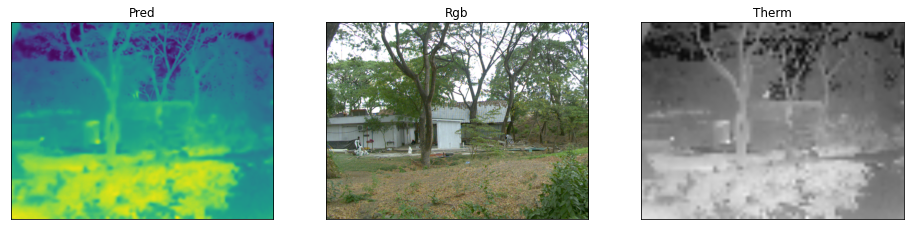

(480, 640) (480, 640, 3) (480, 640, 3)


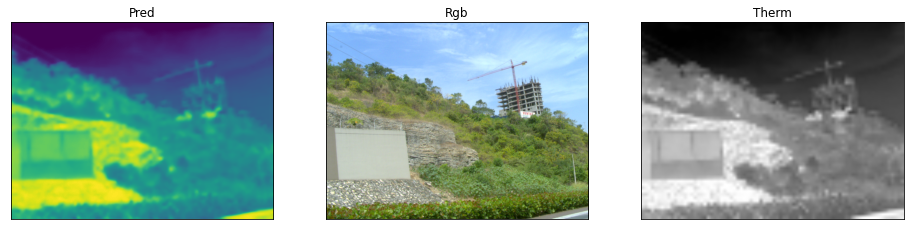

(480, 640) (480, 640, 3) (480, 640, 3)


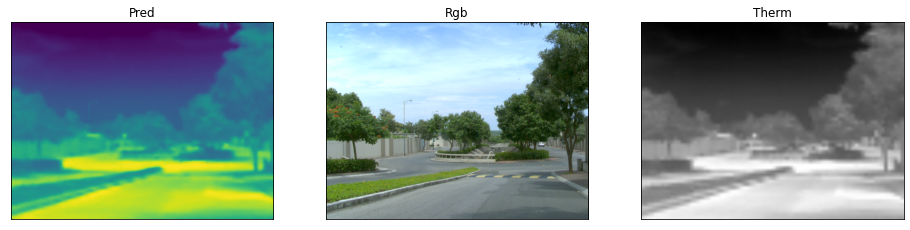

(480, 640) (480, 640, 3) (480, 640, 3)


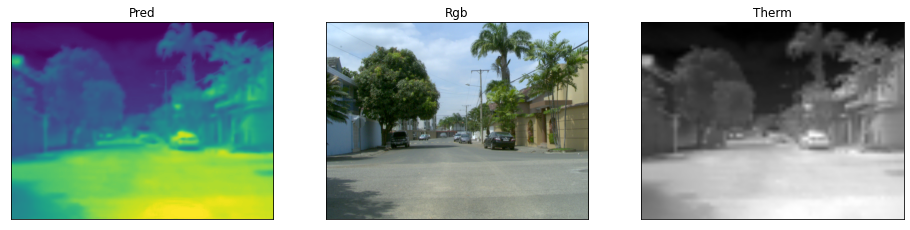

(480, 640) (480, 640, 3) (480, 640, 3)


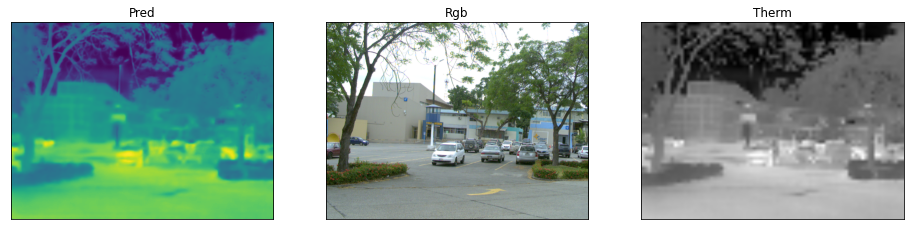

(480, 640) (480, 640, 3) (480, 640, 3)


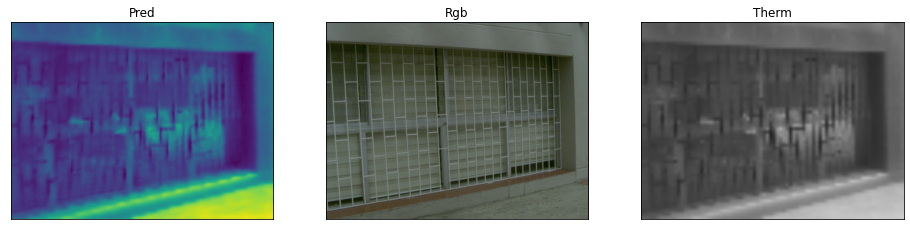

(480, 640) (480, 640, 3) (480, 640, 3)


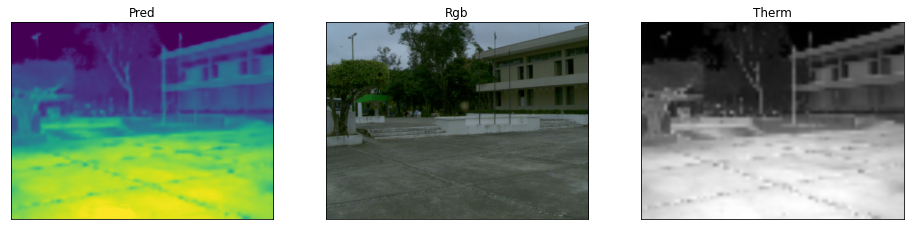

(480, 640) (480, 640, 3) (480, 640, 3)


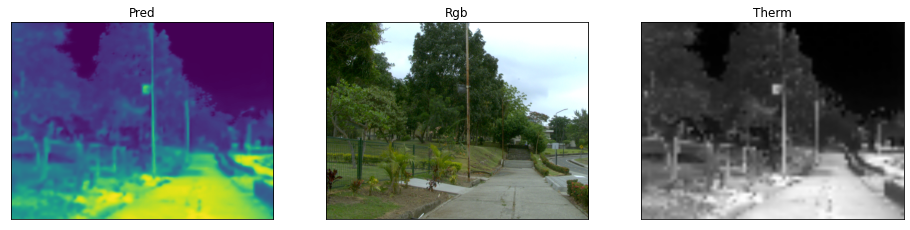

(480, 640) (480, 640, 3) (480, 640, 3)


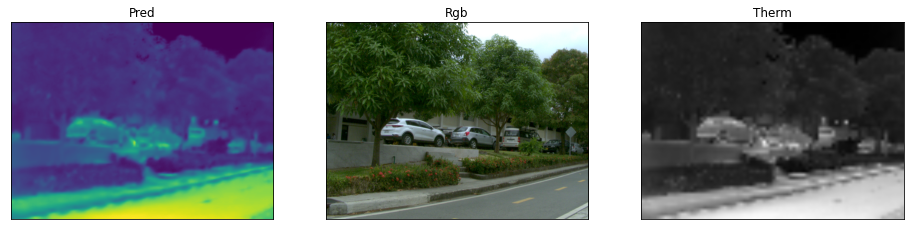

(480, 640) (480, 640, 3) (480, 640, 3)


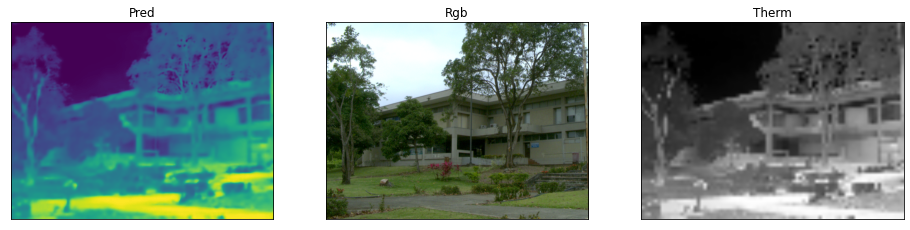

In [4]:
augmentation = get_training_augmentation()
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet34', 'imagenet')
preprocessing = get_preprocessing(preprocessing_fn)
model.load_state_dict(torch.load('/home/aditya/Documents/ThermalModels/best_model_azure_glitter.pth', map_location=torch.device('cpu')))
model.eval()
reshape = albu.Resize(480,640)
s = StructuralSimilarityIndexMeasure()
p = PeakSignalNoiseRatio()
lst = ['evl_001','evl_002','evl_003','evl_004','evl_005','evl_006','evl_007','evl_008','evl_009','evl_010']
for ind in range(len(inputs1)):
    img1_ = cv2.imread(inputs1[ind])
    img1_ = cv2.cvtColor(img1_, cv2.COLOR_BGR2RGB)
    img2_ = cv2.imread(inputs2[ind])
    # img1 = augmentation(image=img1_)['image']
    # img2 = augmentation(image=img2_)['image']
    # img1 = img1_
    img2_ = reshape(image=img2_)['image']
    img1 = preprocessing(image=img1_)['image']
    img2 = preprocessing(image=img2_)['image']
    img1 = torch.from_numpy(img1).unsqueeze(0)
    img2 = torch.from_numpy(img2).unsqueeze(0)
    prd,_,_ = model(img1,img2)
    prd = unnormalize_data(prd)
    prd = prd.detach().numpy().squeeze(0).squeeze(0)
    prd = (prd*255).astype('uint8')
    print(prd.shape,img1_.shape,img2_.shape)
    # plt.imshow(prd, cmap='gray')
    visualize(pred=prd, rgb = img1_, therm = img2_)
    plt.imsave('/home/aditya/Documents/GitHub/ThermalSuperResolution/Dataset/submitStructure/evaluation/x8/'+str(lst[ind])+'.bmp', img2_, cmap='gray')

    

    